In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torchvision import transforms
from torchvision.transforms import RandomApply
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.optim as optim
from tqdm import tqdm
from torchviz import make_dot

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Betöltés

In [3]:
data_dir = Path("../train")
subfolders = ["close_eyes", "open_eyes"]

files = []
for label in subfolders:
    folder = data_dir / label
    if not folder.exists():
        print(f"Mappa nem található: {folder}")
        continue
    for file in folder.iterdir():
        if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            files.append((str(file.resolve()), label))

#random.shuffle(files)

df = pd.DataFrame(files, columns=["filepath", "label"])

print("Összes tanító kép:", len(df))

Összes tanító kép: 81675


In [4]:
test_data_dir = Path("../test")
test_subfolders = ["close_eyes", "open_eyes"]

test_files = []
for label in test_subfolders:
    folder = test_data_dir / label
    if not folder.exists():
        print(f"Mappa nem található: {folder}")
        continue
    for file in folder.iterdir():
        if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            test_files.append((str(file.resolve()), label))

test_df = pd.DataFrame(test_files, columns=["filepath", "label"])
print("Összes teszt kép:", len(test_df))

Összes teszt kép: 3223


In [5]:
full_df = pd.concat([df, test_df], ignore_index=True)

lab = full_df["label"].value_counts()

labels = lab.index.map({
    "open_eyes": "Nyitott szemek",
    "close_eyes": "Zárt szemek"
})

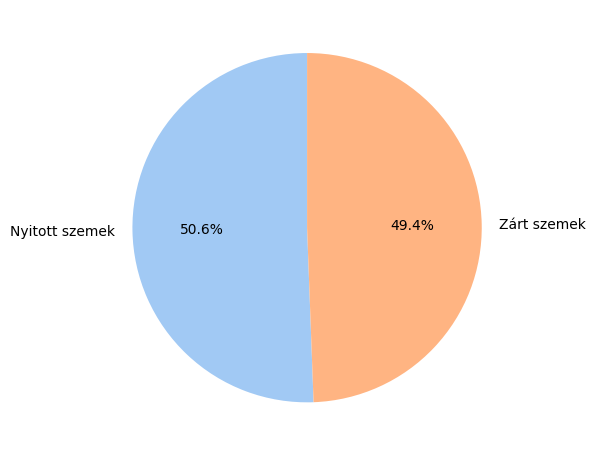

In [6]:
plt.figure(figsize=(6, 6))
plt.pie(lab, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=sns.color_palette("pastel")[0:2])
#plt.title("Osztályok eloszlása a teljes adathalmazban", fontsize=13)
plt.tight_layout()
plt.show()

Előkészítés

In [ ]:
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    ], p=0.2),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05))
    ], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [8]:
class EyesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_map = {"close_eyes": 0, "open_eyes": 1}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("L")
        if self.transform:
            img = self.transform(img)
        label = self.label_map[row["label"]]
        return img, label

In [9]:
BATCH = 32

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

train_dataset = EyesDataset(train_df, transform=transform_train)
val_dataset = EyesDataset(val_df, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}")

Train: 65340, Validation: 16335


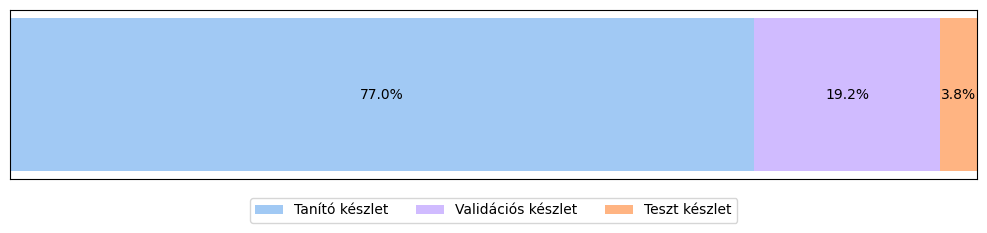

In [10]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

train_ratio = train_size / total
val_ratio = val_size / total
test_ratio = test_size / total

fig, ax = plt.subplots(figsize=(10, 2.5))

ax.barh(0, train_ratio, color="#A1C9F4", label="Tanító készlet")
ax.barh(0, val_ratio, left=train_ratio, color="#D0BBFF", label="Validációs készlet")
ax.barh(0, test_ratio, left=train_ratio + val_ratio, color="#FFB482", label="Teszt készlet")

ax.text(train_ratio / 2, 0, f"{train_ratio * 100:.1f}%", ha="center", va="center", fontsize=10)
ax.text(train_ratio + val_ratio / 2, 0, f"{val_ratio * 100:.1f}%", ha="center", va="center", fontsize=10)
ax.text(train_ratio + val_ratio + test_ratio / 2, 0, f"{test_ratio * 100:.1f}%", ha="center", va="center", fontsize=10)

ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0, 1)
#ax.set_title("Adathalmaz megoszlása", fontsize=12)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()
plt.show()


Model

In [11]:
class EyeCNN(nn.Module):
    def __init__(self):
        super(EyeCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = EyeCNN().to(device)

In [12]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), 
                       lr=0.00005, 
                       weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=3, 
                                                 verbose=True)

In [13]:
num_epochs = 20
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        imgs = imgs.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  # paraméterek frissítése

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_preds.extend(preds.cpu().numpy().flatten().tolist())
        train_labels.extend(labels.cpu().numpy().flatten().tolist())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f}, Training Accuracy: {acc:.4f}")

    # Validáció
    model.eval()
    running_val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float().view(-1, 1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_preds.extend(preds.cpu().numpy().flatten().tolist())
            val_labels.extend(labels.cpu().numpy().flatten().tolist())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)
    print(f"Validation: Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

    scheduler.step(avg_val_loss)  # tanulási ráta frissítése

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print("Stop")
        break


Training Epoch 1/20: 100%|██████████| 2042/2042 [10:22<00:00,  3.28it/s]  


Epoch 1: Loss: 0.1725, Training Accuracy: 0.9330
Validation: Loss: 0.0711, Accuracy: 0.9747


Training Epoch 2/20: 100%|██████████| 2042/2042 [01:52<00:00, 18.09it/s]


Epoch 2: Loss: 0.0878, Training Accuracy: 0.9689
Validation: Loss: 0.0606, Accuracy: 0.9793


Training Epoch 3/20: 100%|██████████| 2042/2042 [01:50<00:00, 18.42it/s]


Epoch 3: Loss: 0.0730, Training Accuracy: 0.9738
Validation: Loss: 0.0490, Accuracy: 0.9824


Training Epoch 4/20: 100%|██████████| 2042/2042 [01:50<00:00, 18.54it/s]


Epoch 4: Loss: 0.0629, Training Accuracy: 0.9767
Validation: Loss: 0.0462, Accuracy: 0.9836


Training Epoch 5/20: 100%|██████████| 2042/2042 [01:50<00:00, 18.51it/s]


Epoch 5: Loss: 0.0596, Training Accuracy: 0.9797
Validation: Loss: 0.0799, Accuracy: 0.9736


Training Epoch 6/20: 100%|██████████| 2042/2042 [01:53<00:00, 17.91it/s]


Epoch 6: Loss: 0.0537, Training Accuracy: 0.9814
Validation: Loss: 0.0415, Accuracy: 0.9852


Training Epoch 7/20: 100%|██████████| 2042/2042 [01:50<00:00, 18.47it/s]


Epoch 7: Loss: 0.0510, Training Accuracy: 0.9823
Validation: Loss: 0.0392, Accuracy: 0.9860


Training Epoch 8/20: 100%|██████████| 2042/2042 [01:49<00:00, 18.67it/s]


Epoch 8: Loss: 0.0474, Training Accuracy: 0.9829
Validation: Loss: 0.0420, Accuracy: 0.9854


Training Epoch 9/20: 100%|██████████| 2042/2042 [01:49<00:00, 18.57it/s]


Epoch 9: Loss: 0.0463, Training Accuracy: 0.9838
Validation: Loss: 0.0383, Accuracy: 0.9863


Training Epoch 10/20: 100%|██████████| 2042/2042 [01:49<00:00, 18.64it/s]


Epoch 10: Loss: 0.0434, Training Accuracy: 0.9846
Validation: Loss: 0.0353, Accuracy: 0.9875


Training Epoch 11/20: 100%|██████████| 2042/2042 [01:49<00:00, 18.65it/s]


Epoch 11: Loss: 0.0427, Training Accuracy: 0.9854
Validation: Loss: 0.0350, Accuracy: 0.9878


Training Epoch 12/20: 100%|██████████| 2042/2042 [01:50<00:00, 18.53it/s]


Epoch 12: Loss: 0.0407, Training Accuracy: 0.9858
Validation: Loss: 0.0380, Accuracy: 0.9871


Training Epoch 13/20: 100%|██████████| 2042/2042 [01:50<00:00, 18.46it/s]


Epoch 13: Loss: 0.0399, Training Accuracy: 0.9864
Validation: Loss: 0.0317, Accuracy: 0.9883


Training Epoch 14/20: 100%|██████████| 2042/2042 [01:51<00:00, 18.40it/s]


Epoch 14: Loss: 0.0375, Training Accuracy: 0.9868
Validation: Loss: 0.0323, Accuracy: 0.9882


Training Epoch 15/20: 100%|██████████| 2042/2042 [01:50<00:00, 18.54it/s]


Epoch 15: Loss: 0.0374, Training Accuracy: 0.9866
Validation: Loss: 0.0311, Accuracy: 0.9887


Training Epoch 16/20: 100%|██████████| 2042/2042 [01:49<00:00, 18.59it/s]


Epoch 16: Loss: 0.0358, Training Accuracy: 0.9875
Validation: Loss: 0.0334, Accuracy: 0.9881


Training Epoch 17/20: 100%|██████████| 2042/2042 [01:50<00:00, 18.48it/s]


Epoch 17: Loss: 0.0346, Training Accuracy: 0.9876
Validation: Loss: 0.0301, Accuracy: 0.9890


Training Epoch 18/20: 100%|██████████| 2042/2042 [01:50<00:00, 18.50it/s]


Epoch 18: Loss: 0.0348, Training Accuracy: 0.9879
Validation: Loss: 0.0374, Accuracy: 0.9858


Training Epoch 19/20: 100%|██████████| 2042/2042 [01:50<00:00, 18.50it/s]


Epoch 19: Loss: 0.0332, Training Accuracy: 0.9884
Validation: Loss: 0.0295, Accuracy: 0.9888


Training Epoch 20/20: 100%|██████████| 2042/2042 [01:49<00:00, 18.57it/s]


Epoch 20: Loss: 0.0339, Training Accuracy: 0.9879
Validation: Loss: 0.0308, Accuracy: 0.9892


In [14]:
val_precision = precision_score(val_labels, val_preds, zero_division=0)
val_recall = recall_score(val_labels, val_preds, zero_division=0)
val_f1 = f1_score(val_labels, val_preds, zero_division=0)

print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-score: {val_f1:.4f}")

Precision: 0.9888
Recall: 0.9900
F1-score: 0.9894


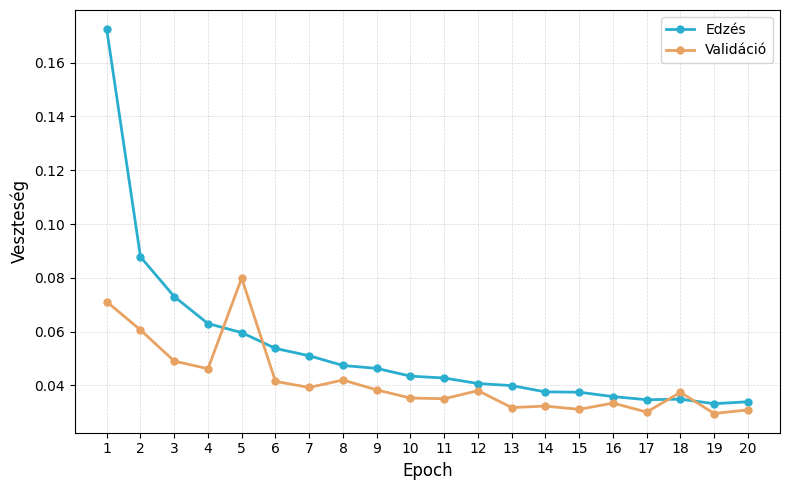

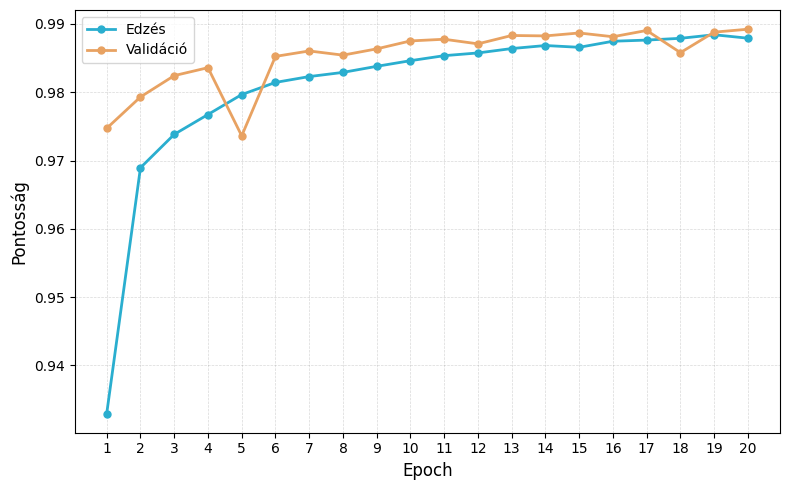

In [15]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label="Edzés", marker="o", markersize=5, linewidth=2, color='#2AAECF')
plt.plot(epochs_range, val_losses, label="Validáció", marker="o", markersize=5, linewidth=2, color='#E8A262')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Veszteség", fontsize=12)
#plt.title("Veszteség alakulása", fontsize=14)
plt.legend(fontsize=10)
plt.xticks(ticks=epochs_range)
plt.grid(True, color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, label="Edzés", marker="o", markersize=5, linewidth=2, color='#2AAECF')
plt.plot(epochs_range, val_accuracies, label="Validáció", marker="o", markersize=5, linewidth=2, color='#E8A262')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Pontosság", fontsize=12)
#plt.title("Pontosság alakulása", fontsize=14)
plt.legend(fontsize=10)
plt.xticks(ticks=epochs_range)
plt.grid(True, color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Teszt

In [16]:
test_dataset = EyesDataset(test_df, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

In [17]:
model.eval()
running_test_loss = 0.0
test_preds, test_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_preds.extend(preds.cpu().numpy().flatten().tolist())
        test_labels.extend(labels.cpu().numpy().flatten().tolist())

avg_test_loss = running_test_loss / len(test_loader)
test_acc = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, zero_division=0)
test_recall = recall_score(test_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_labels, test_preds, zero_division=0)

print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")

Precision: 0.9986
Recall: 0.8431
F1-score: 0.9143


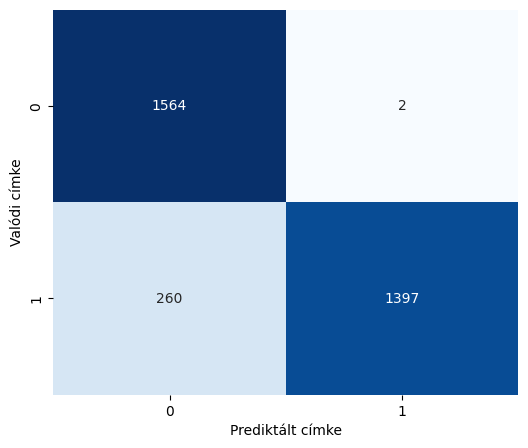

In [18]:
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prediktált címke')
plt.ylabel('Valódi címke')
#plt.title('Konfúziós mátrix a teszthalmazon')
plt.show()

Mentés

In [19]:
#torch.save(model.state_dict(), "test2e.pth")
#print("modell mentve")

modell mentve
